In [3]:
# Mounting the google colab drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Using the dataset from Kaggle to identify if there are any plant diseases requiring pesticide prescription

https://www.kaggle.com/sangeevan/dataset-pesticides-prescription-for-leaf-diseases

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

train_dir = pathlib.Path("Dataset_Pesticides_Prescription_For_Leaf_Diseases/train")
test_dir = pathlib.Path("Dataset_Pesticides_Prescription_For_Leaf_Diseases/test")
val_dir = pathlib.Path("Dataset_Pesticides_Prescription_For_Leaf_Diseases/val")

In [3]:
train_img_count = len(list(train_dir.glob('*/*.JPG')))
print(f"Number of train images: {train_img_count}")
test_img_count = len(list(test_dir.glob('*/*.JPG')))
print(f"Number of test images: {test_img_count}")
val_img_count = len(list(val_dir.glob('*/*.JPG')))
print(f"Number of validation images: {val_img_count}")

Number of train images: 15115
Number of test images: 1903
Number of validation images: 1892


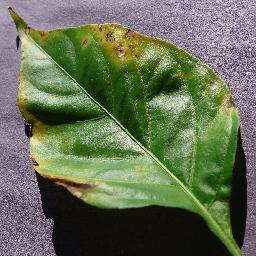

In [4]:
#each directory contains images of some leaf with some ailment
#let's check the bell pepper bacterial spot image in train dataset
Bell_pepper__Bacterial_spot = list(train_dir.glob('Bell_pepper__Bacterial_spot/*'))
PIL.Image.open(str(Bell_pepper__Bacterial_spot[0]))

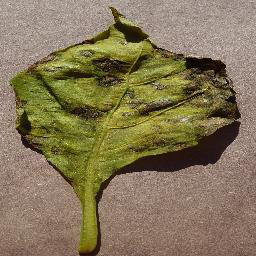

In [5]:
PIL.Image.open(str(Bell_pepper__Bacterial_spot[10]))

## Load data using a Keras utility

Create a dataset

In [6]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
#load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15245 files belonging to 15 classes.


2022-01-10 13:57:45.786844: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#load val dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1901 files belonging to 15 classes.


In [9]:
#load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1917 files belonging to 15 classes.


In [10]:
#print class names in test dataset
class_names = train_ds.class_names
print(class_names)

['Bell_pepper__Bacterial_spot', 'Bell_pepper__Healthy', 'Potato__Early_blight', 'Potato__Healthy', 'Potato__Late_blight', 'Tomato__Bacterial_spot', 'Tomato__Early_blight', 'Tomato__Healthy', 'Tomato__Late_blight', 'Tomato__Leaf_mold', 'Tomato__Mosaic_virus', 'Tomato__Septoria_leaf_spot', 'Tomato__Target_spot', 'Tomato__Two_spotted_spider_mite', 'Tomato__Yellow_leaf_curl_virus']


## Visualize the data

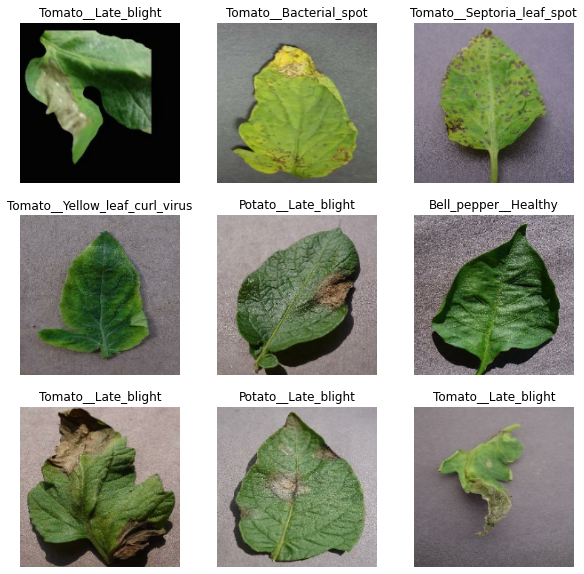

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

#Dataset.prefetch overlaps data preprocessing and model execution while training.

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Standardize the data

In [93]:
# standardize values to be in the [0, 1] range
normalization_layer = layers.Rescaling(1./255)

#we include this layer inside our model definition

## Create the model

In [94]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

## Compile the model

In [95]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Model summary

In [96]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

## Train the model

In [97]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
477/477 [==============================] - 400s 835ms/step - loss: 1.0775 - accuracy: 0.6529 - val_loss: 0.7078 - val_accuracy: 0.7554
Epoch 2/10
477/477 [==============================] - 418s 876ms/step - loss: 0.4319 - accuracy: 0.8537 - val_loss: 0.4108 - val_accuracy: 0.8685
Epoch 3/10
477/477 [==============================] - 382s 798ms/step - loss: 0.2463 - accuracy: 0.9171 - val_loss: 0.4376 - val_accuracy: 0.8653
Epoch 4/10
477/477 [==============================] - 396s 830ms/step - loss: 0.1508 - accuracy: 0.9486 - val_loss: 0.5162 - val_accuracy: 0.8432
Epoch 5/10
477/477 [==============================] - 409s 857ms/step - loss: 0.1225 - accuracy: 0.9603 - val_loss: 0.5593 - val_accuracy: 0.8595
Epoch 6/10
477/477 [==============================] - 369s 773ms/step - loss: 0.1019 - accuracy: 0.9658 - val_loss: 0.5708 - val_accuracy: 0.8674
Epoch 7/10
477/477 [==============================] - 377s 790ms/step - loss: 0.0865 - accuracy: 0.9683 - val_loss: 0.4911 -

# Save the model

In [99]:
!pip install pyyaml h5py

In [100]:
# save model and architecture to single file
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('plant_disease.h5') 
print('model saved to hackathon folder')

model saved to hackathon folder


## Visualize training results

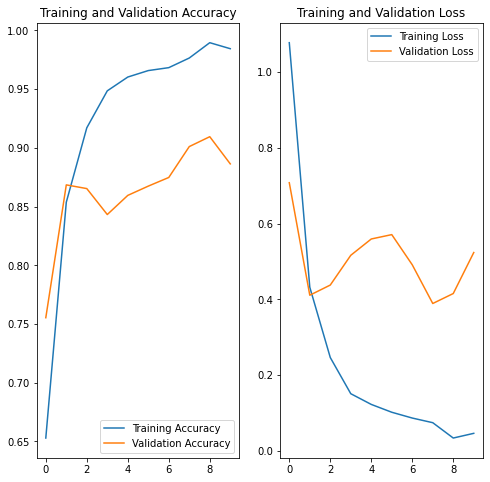

In [101]:
#Create plots of loss and accuracy on the training and validation sets:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Classify Test Data

In [13]:
#load the model
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('plant_disease.h5')

In [14]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [15]:
#get testing accuracy
loss, accuracy = new_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

60/60 [==============================] - 17s 265ms/step - loss: 0.4510 - accuracy: 0.9004
Test accuracy : 0.9003651738166809


Predictions:
 [13, 8, 14, 12, 5, 5, 6, 4, 12, 0, 10, 7, 11, 2, 8, 13, 5, 14, 8, 12, 9, 11, 0, 5, 9, 4, 1, 1, 11, 5, 14, 2]
Labels:
 [13  8 14 13  5  5  6  4 12  2 10  7 11  2  8 13  5 14  8 12  9 11  0  5
  9  4  1  1 11  5 14  2]


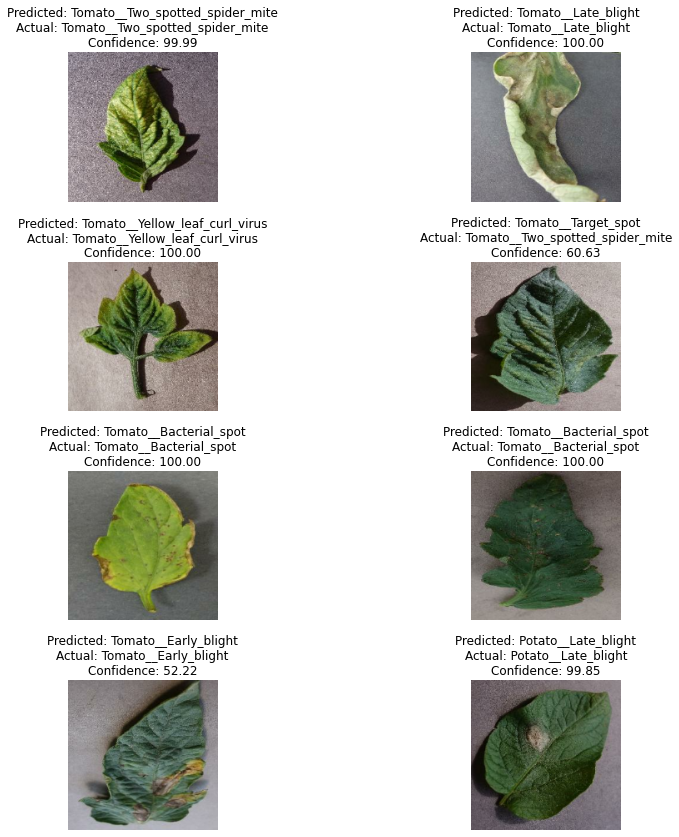

In [16]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch)

#get the predicted class with highest score
predicted_labels = [np.argmax(pred) for pred in predictions]

#get the confidence level for each of the predicted labels
confidence = [100 * np.max(pred) for pred in predictions]

print('Predictions:\n', predicted_labels)
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
  # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[label_batch[i]]}\nConfidence: {confidence[i]:.2f}")

    plt.axis("off")

# Predict on new data

In [18]:
#image downloaded from internet
healthy_leaf_path = "healthy_tomato_leaf.jpeg"

img = tf.keras.utils.load_img(
    healthy_leaf_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Tomato__Late_blight with a 99.34 percent confidence.


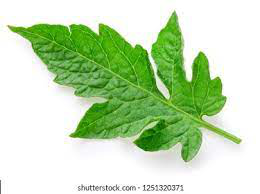

In [19]:
PIL.Image.open(healthy_leaf_path)

if images are in the same format as the one used for testing then the results are better. Below are some test images which were not shown to the model when training. They seem to predict the correct class with high certainity.

In [20]:
#TOMATO target spot image
diseased_leaf_path = "tomato_target_spot.JPG"

img = tf.keras.utils.load_img(
    diseased_leaf_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Tomato__Target_spot with a 100.00 percent confidence.


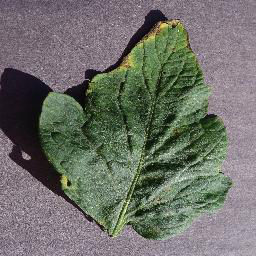

In [21]:
PIL.Image.open(diseased_leaf_path)

In [23]:
#Potato healthy
potato_healthy = "potato_healthy.JPG"

img = tf.keras.utils.load_img(
    potato_healthy, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Potato__Healthy with a 99.76 percent confidence.


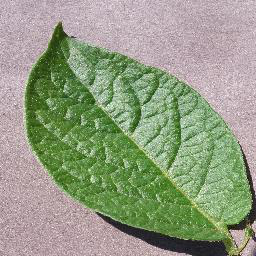

In [24]:
PIL.Image.open(potato_healthy)

# Save the model for future use

In [ ]:
# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")